# Serial Position Cell Analysis

Analyze TH data for serial positon cells. 

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import numpy as np
from scipy.stats import sem

from convnwb.io import load_nwbfile

from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.measures.trials import compute_segment_frs
from spiketools.plts.spatial import plot_positions
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.plts.data import plot_bar
from spiketools.plts.annotate import color_pval
from spiketools.utils import set_random_seed
from spiketools.utils.extract import (get_range, get_value_by_time,
                                      get_values_by_time_range, get_values_by_times)

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from models import create_df_serial, fit_anova_serial

# Settings

In [5]:
# Set random seed, for consistency shuffling
set_random_seed(101)

In [6]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/NWB')
#data_folder = Path('/scratch/tom.donoghue/TH/NWB')
#data_folder = Path('/Users/Claire_han/Documents/Data/JacobsLab/TH/NWB')

In [7]:
# Define subject information
session = {
    'task' : 'THF',
    'subject' : 'wv001',
    'session' : 2    
}

In [8]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 25

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}

In [9]:
# Set example unit to analyze
uind = 74

In [10]:
# Set which analysis method to run
METHOD = 'ANOVA'  # 'SEGMENT' / 'ANOVA'

# Load Data

In [11]:
# Load NWB file
nwbfile = load_nwbfile(session, data_folder)

#### Get Trial Data

In [12]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [13]:
# Extract behavioural markers of interest
nav_starts = nwbfile.trials['navigation_start'].data[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]

In [14]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)

#### Get Unit Data

In [15]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [16]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

#### Get Position Data

In [17]:
# Extract the position data
ptimes = nwbfile.acquisition['position']['player_position'].timestamps[:]
positions = nwbfile.acquisition['position']['player_position'].data[:].T

In [18]:
# Get the chest positions & trial indices
chest_xs, chest_ys = nwbfile.acquisition['stimuli']['chest_positions'].data[:].T
chest_trials = nwbfile.trials.chest_trials[:]

# Single Trial

In [19]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['navigation_start'][t_ind]
ch_openings = nwbfile.trials['chest_opening_time'][t_ind]
t_en = ch_openings[-1]

In [20]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [21]:
# Select chest openings for the current trial
t_time, t_pos = get_values_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [22]:
# Restrict spikes to the selected trial, and get spike positions
t_spikes = get_range(spikes, t_st, t_en)
spike_positions = get_values_by_times(t_time, t_pos, t_spikes, threshold=0.25)

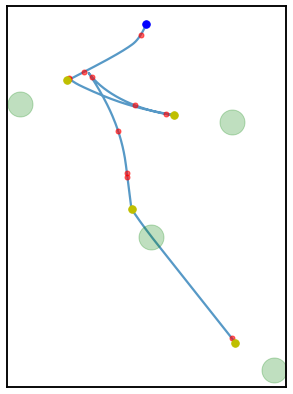

In [23]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
tspikes = {'positions' : spike_positions, 'ms' : 10, 'alpha' : 0.6}
landmarks = [{'positions' : np.array([chest_xs[t_mask], chest_ys[t_mask]]),
              'color' : 'green', 'ms' : 50, 'alpha' : 0.25},
             {'positions' : np.atleast_2d(t_pos[:, 0]).T, 'color' : 'blue', 'ms' : 15},
             {'positions' : np.array(ch_times).T, 'color' : 'y', 'ms' : 15}]
plot_positions(t_pos, tspikes, landmarks, alpha=0.75, figsize=(5, 7))

# Serial Position

### Single Trial

In [24]:
# Compute firing rate across each serial position segment
frs = convert_times_to_rates(t_spikes, seg_times[t_ind, :])

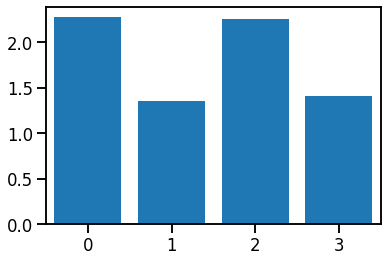

In [25]:
# Plot firing rate per segment (single trial)
plot_bar(frs, [0, 1, 2, 3])

### All Trials

In [26]:
# Compute firing rates per segment for all trials
all_frs = compute_segment_frs(spikes, seg_times)

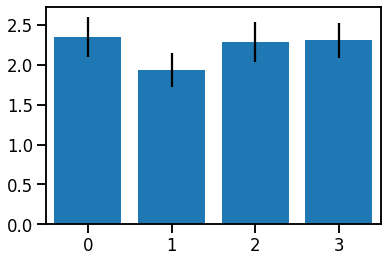

In [27]:
# Plot firing rates per segment across all trials
plot_bar(all_frs.mean(0), [0, 1, 2, 3], yerr=sem(all_frs, 0))

## Statistical Analyses

In [28]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

## ANOVA Analysis

In [29]:
# Create dataframe
df = create_df_serial(all_frs)

In [30]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)
f_val

0.6402260571362254

In [31]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    all_frs = compute_segment_frs(shuffle, seg_times)
    df = create_df_serial(all_frs)
    surrogates[ind] = fit_anova_serial(df)

In [32]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.16
z-score: 0.36


# All Cells

In [33]:
# # Plot the firing rate per segment across trials for all units
# for ii, ax in zip(keep_inds, make_axes(n_keep, hspace=0.4, wspace=0.4)):

#     spikes = nwbfile.units.get_unit_spike_times(ii)

#     seg_frs = compute_segment_frs(spikes, seg_times)
    
#     # Compute real data value
#     if METHOD == 'ANOVA':
#         data_value = fit_anova_serial(create_df_serial(seg_frs))

#     # Compute measures on surrogates
#     surrogates = np.zeros(n_surrogates)
#     times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
#     for ind, shuffle in enumerate(times_shuffle):

#         surr_seg_frs = compute_segment_frs(shuffle, seg_times)

#         if METHOD == 'ANOVA':
#             surrogates[ind] = fit_anova_serial(create_df_serial(surr_seg_frs))

#     # Compute z-score & p-value based on surrogates
#     p_val, z_score = compute_surrogate_stats(data_value, surrogates)
    
#     # Plot firing across serial positions
#     plot_bar(all_frs.mean(0), [0, 1, 2, 3], yerr=sem(all_frs, 0),
#              title='U{} \n z-{:1.2f}, p-{:1.2f}'.format(ii, z_score, p_val),
#              title_color=color_pval(p_val),
#              ax=ax)